## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 Part 1: Regression**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset. Our task is to predict disease progression of diabetes, given some variables such as age, sex, body mass index, blood pressure and blood serum measurements. For more details, follow the link above.

In [1]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

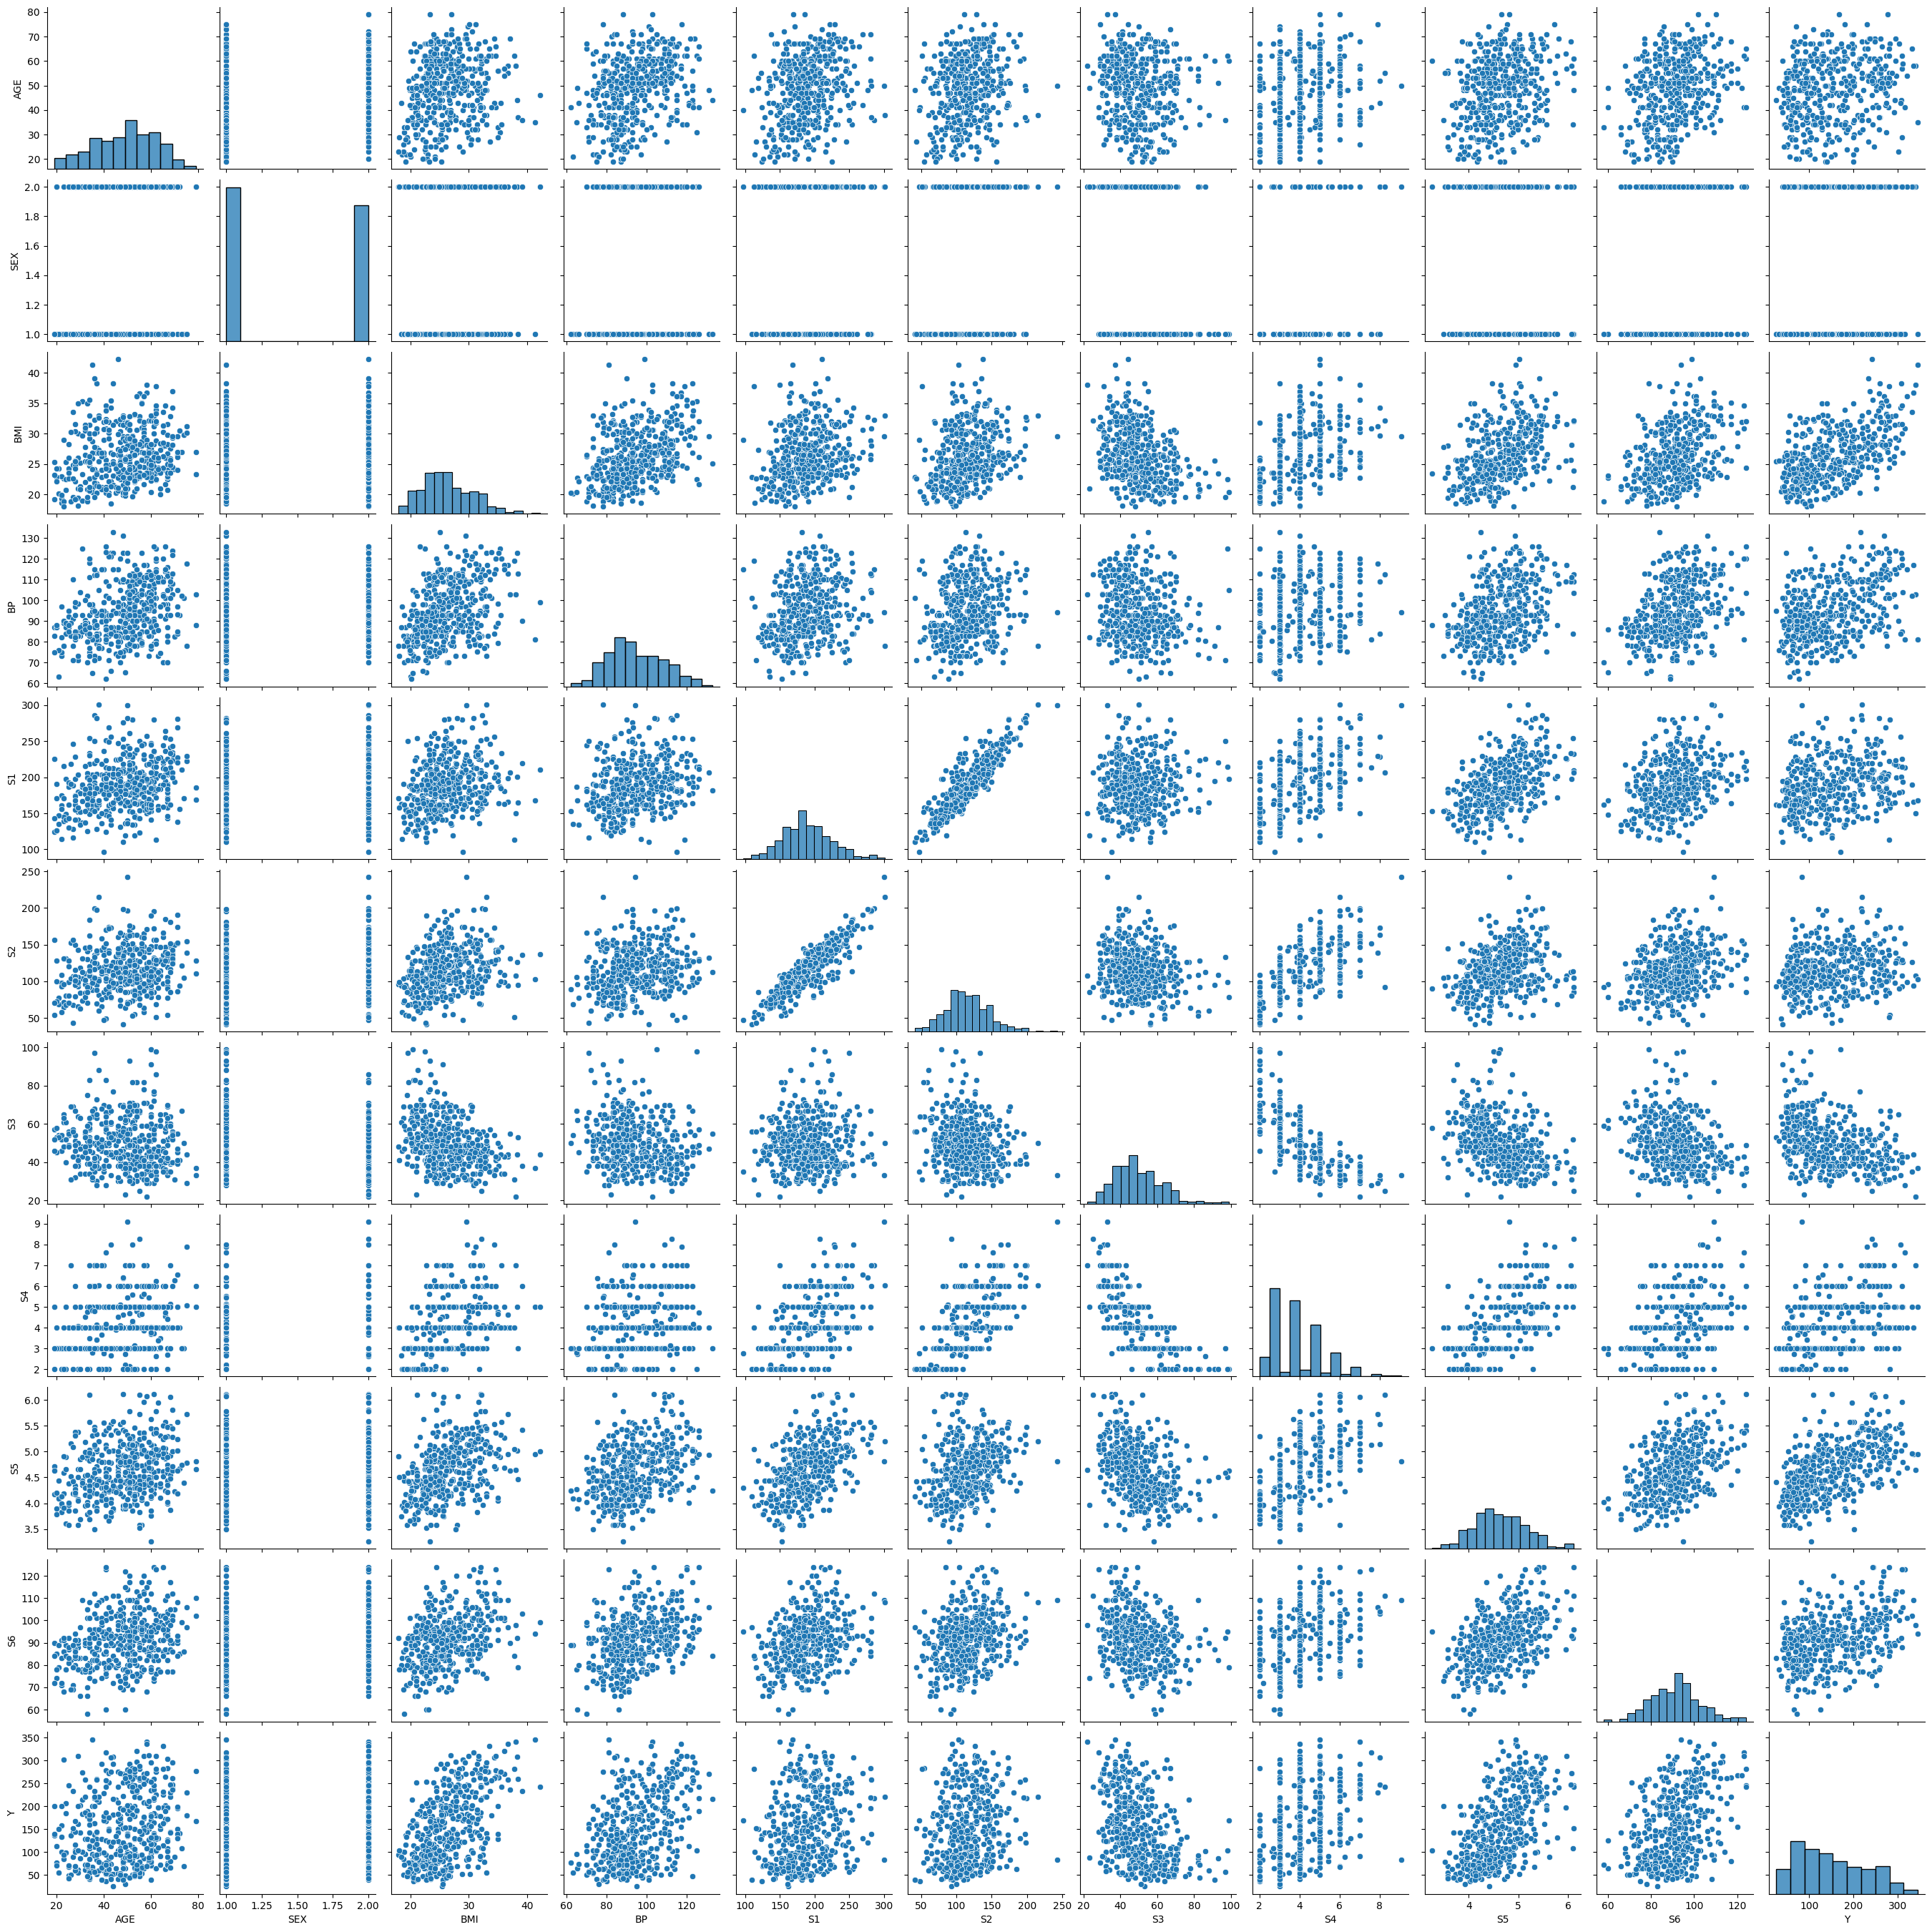

In [2]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
sn.pairplot(diabetes_db)

In [3]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [5]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
  return (x - mu) / sigma

mu = x_train.mean(dim=0, keepdim=True)
sigma = x_train.std(dim=0, unbiased=False, keepdim=True)
sigma = torch.where(sigma == 0, torch.ones_like(sigma), sigma)

x_train = norm_set(x_train, mu, sigma)
x_test = norm_set(x_test, mu, sigma)

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [6]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(1, num_features), requires_grad=False)

  def forward(self, x):
    y = x @ self.weight.T
    return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [7]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [8]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [9]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  squared_diff = (y_pred - y_true) ** 2
  mse = squared_diff.mean()
  return mse

In [10]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29029.0703)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [11]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  error = y_pred - y
  grad = (2.0 / N) * (error.T @ X)
  weight = weight - lr * grad
  model.weight = nn.Parameter(weight, requires_grad=False)

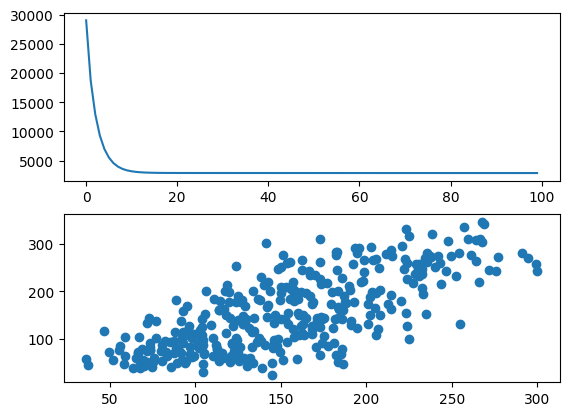

Parameter containing:
tensor([[  1.9385, -11.4373,  26.2644,  16.6137, -10.1936,  -2.1171,  -7.4778,
           8.3604,  22.0374,   2.5998, 153.7365]])
Minimum cost: 2890.0


In [12]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = 0.1
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does sex and BMI affect diabetes disease progression?

What are the estimated disease progression values for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

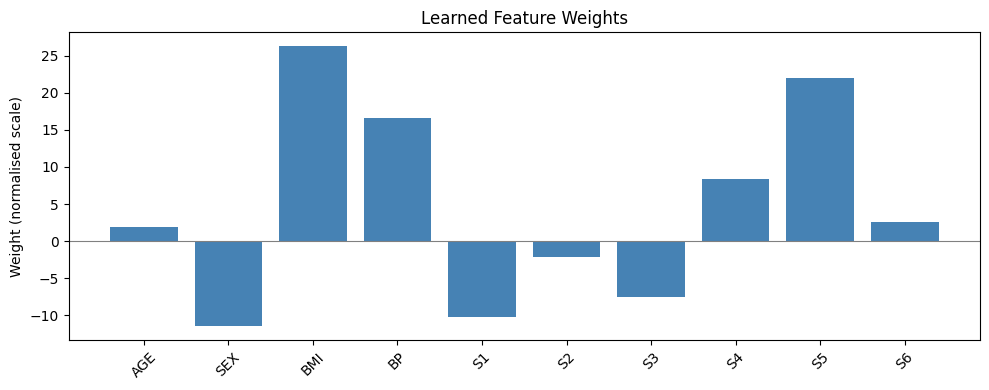

Bias weight: 153.7365


,Predicted_Progression
0,112.350388
1,232.637573


In [13]:
weights = model.weight.detach().numpy().flatten()
feature_names = list(X_train.columns) + ['bias']
weight_table = pd.Series(weights, index=feature_names)

plt.figure(figsize=(10, 4))
plt.bar(weight_table.index[:-1], weight_table.iloc[:-1], color='steelblue')
plt.axhline(0.0, color='grey', linewidth=0.8)
plt.ylabel('Weight (normalised scale)')
plt.title('Learned Feature Weights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Bias weight: {weight_table['bias']:.4f}")

patients = pd.DataFrame(
    [
        {'AGE': 25, 'SEX': 'F', 'BMI': 18, 'BP': 79,  'S1': 130, 'S2': 64.8, 'S3': 61, 'S4': 2.0, 'S5': 4.1897, 'S6': 68},
        {'AGE': 50, 'SEX': 'M', 'BMI': 28, 'BP': 103, 'S1': 229, 'S2': 162.2, 'S3': 60, 'S4': 4.5,  'S5': 6.107,  'S6': 124},
    ]
)
patients['SEX'] = patients['SEX'].map({'F': -1.0, 'M': 1.0})

mu_features = mu[..., :len(X_train.columns)]
sigma_features = sigma[..., :len(X_train.columns)]
patient_tensor = torch.tensor(patients.values, dtype=torch.float32)
patient_tensor = norm_set(patient_tensor, mu_features, sigma_features)
patient_tensor = torch.cat([patient_tensor, torch.ones(patient_tensor.shape[0], 1)], dim=1)

patients['Predicted_Progression'] = model(patient_tensor).detach().numpy().flatten()
display.display(patients[['Predicted_Progression']])

Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?



In [14]:
# Calculate test set error
test_prediction = model(x_test)
test_error = mean_squared_error(test_prediction, y_test)

# Training error (from previous cell)
train_prediction = model(x_train)
train_error = mean_squared_error(train_prediction, y_train)
generalization_gap = abs(test_error.item() - train_error.item())

print(f"Training MSE: {train_error.item():.2f}")
print(f"Test MSE: {test_error.item():.2f}")
print(f"Generalization gap: {generalization_gap:.2f}")
print(f"This small generalization gap shows that model is generalizing well")

Training MSE: 2889.92
Test MSE: 2886.15
Generalization gap: 3.77
This small generalization gap shows that model is generalizing well


<font color="maroon">**Q6.** Try the code with several learning rates that differ by orders of magnitude, and record the training and test set errors. Describe the theory of how changing the learning rate affects learning. What do you observe in the training error? How about the error on the test set? [3 marks]</font>

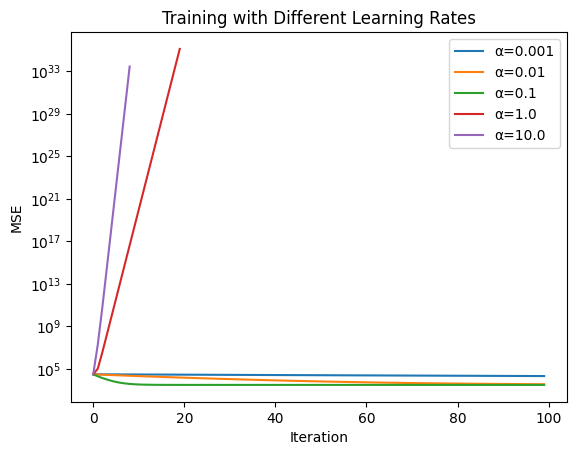

        α     Train MSE      Test MSE
0   0.001  19767.199219  18346.466797
1   0.010   3351.017090   3425.627441
2   0.100   2890.000000   2886.150879
3   1.000           NaN           NaN
4  10.000           NaN           NaN


In [15]:
# Try different alphas
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
results = []

for alpha in alphas:
    model = LinearRegression(x_train.shape[1])
    costs = []
    
    for it in range(100):
        pred = model(x_train)
        cost = mean_squared_error(pred, y_train)
        costs.append(cost.item())
        gradient_descent_step(model, x_train, y_train, pred, alpha)
    
    # Check test error
    test_pred = model(x_test)
    test_mse = mean_squared_error(test_pred, y_test).item()
    
    results.append([alpha, costs[-1], test_mse])
    plt.plot(costs, label=f'α={alpha}')

plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Training with Different Learning Rates')
plt.legend()
plt.yscale('log')
plt.show()

# Show table
results_df = pd.DataFrame(results, columns=['α', 'Train MSE', 'Test MSE'])
print(results_df)

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

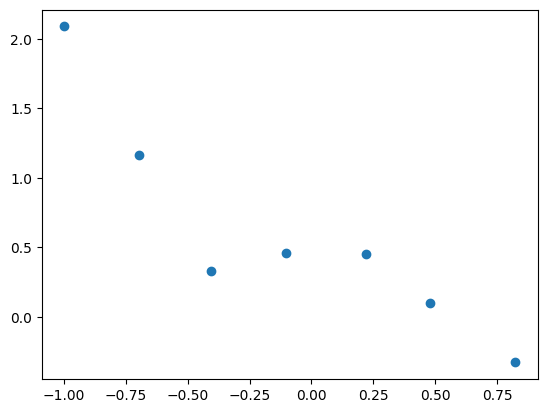

In [16]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

Adjust variable `x` to include the different powers of $x_{1}$ as described by the hypothesis function. e.g $x_{1}, x_{1} ^2, ..., x_{1}^5$. Hint: Remember to include $x_0$ which is our bias term.

In [17]:
### your code here. please assign it to the python object 'x3'. e.g x3 = .....

x = x.reshape(-1, 1)
x3 = torch.cat([torch.ones(x.shape[0], 1), x, x**2, x**3, x**4, x**5], dim=1)


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [18]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
  m = y_true.size(0)
  
  # Calculating the mean squared error
  mse = (1 / (2 * m)) * torch.sum((y_pred - y_true)**2)
  regularization = (lam / (2 * m)) * torch.sum(theta[:, 1:] ** 2)
  cost = mse + regularization

  return cost


def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
  weight = model.weight
  N = X.shape[0]
  
  # Calculate error for all samples
  error = y_pred - y
  
  # Computing base gradient: (1/m) * X^T * error
  gradient = (1 / N) * (error.T @ X)
  
  # Update bias term (theta_0) without regularization
  weight[:, 0] = weight[:, 0] - lr * gradient[:, 0]
  
  # Updating other weights (theta_j, j>0) with L2 regularization (check notes for L2)
  weight[:, 1:] = weight[:, 1:] * (1 - lr * lam / N) - lr * gradient[:, 1:]
  
  model.weight = nn.Parameter(weight, requires_grad=False)

<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

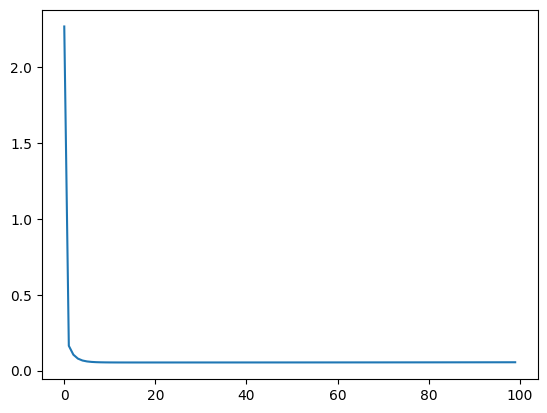

Parameter containing:
tensor([[ 0.3615, -0.4066,  0.1094, -0.3851,  0.1594, -0.3276]])
Minimum cost: 0.053171880543231964


In [19]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 1.41 # select an appropriate alpha
lam = 1 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))


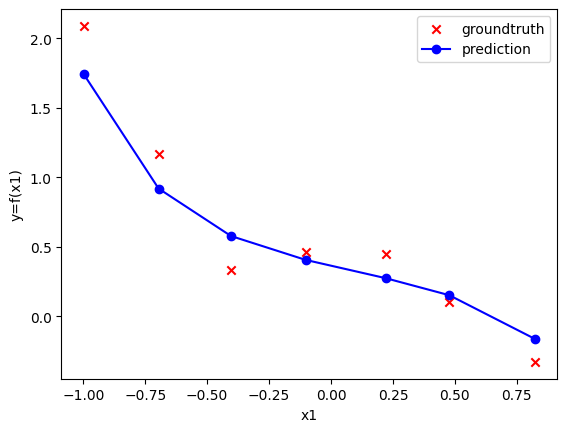

In [20]:
plt.scatter(x3[:, 1], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()